In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Исследуем целевую переменную

In [7]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [ ]:
В целом и без графика понятно распределение целевой переменной. Она принимает всего 2 значения.

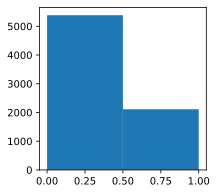

In [10]:
df['Credit Default'].hist(figsize=(3,3), bins=2, grid=False)

### Исследуем признаки

Посчитаем основные статистики по каждому признаку (минимальные, максимальные, средние значения)

In [16]:
train = df.drop('Credit Default', axis = 1)

In [20]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe55a15c160>,
      dtype=object)

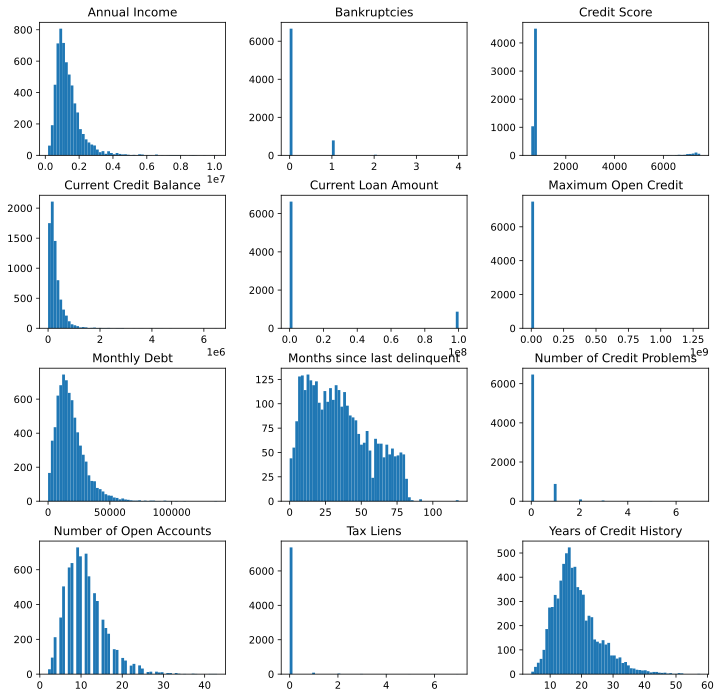

In [18]:
train.hist(figsize=(12,12), bins=60, grid=False)

**Annual income** - нормальное распределение смещенное влево. Людей с доходом больше 1,6млн не много. Приводить их к среднему наверно не стоит. Введем для таких новую переменную "Rich"

In [29]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Tax Liens** - больше 90% значений лежат на значений "0,0". Предлагаю сделать из этой перменной категориальную и поменять значения отличные от 0 на еденицу 

**Number of Open Accounts** - нормальное распределение немного смещенное влево. Можем заменить на мединные значения выше 25.

**Years of Credit History** - нормальное распределение немного смещенное влево. Я думаю тут прямая корреляция с возрастом человека и можно попроовать создать отдельный признак для тех чья кредитная история больше 40-45 лет. Это явно уже люди пожилые по которым есть повышенные риски не возврата.

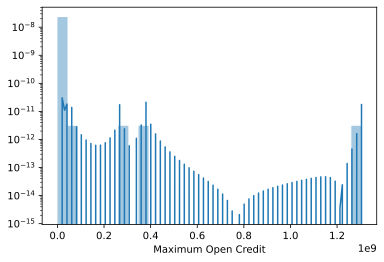

In [47]:
g = sns.distplot(train['Maximum Open Credit'], bins=30)
g.set_yscale('log')

**Maximum Open Credit** - сложно что то сказать по этому графику. Надо будет проверить нули. Если это люди которые не брали кредиты, то сделать для них отдельный категориальный признак. Можно еще посмотреть на корреляцию этого признака с целевой переменной.

In [48]:
train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Number of Credit Problems** - Все у кого 2е и больше проблемы можно считать выбросом. Заменим все значения больше 0 на 1. Разделим всех на проблемных и не проблемных

**Months since last delinquent** - достаточно ровное распределние. Всех у кого больше 75 дней просрочки можно заменить на 75% квантиль.